In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 5]

# Gaussian process models for stellar variability

When fitting exoplanets, we also need to fit for the stellar variability and Gaussian Processes (GPs) are often a good descriptive model for this variation.
[*PyMC3* has support for all sorts of general GP models](https://docs.pymc.io/gp.html), but *exoplanet* includes support for scalable 1D GPs (see :ref:`gp` for more info) that can work with large datasets.
In this tutorial, we go through the process of modeling the light curve of a rotating star observed by Kepler using *exoplanet*.

First, let's download and plot the data:

# Reading BRITE Data

In [20]:
import pandas as pd
brite='HD37128_OrionIII-2015_UBr_finalb_dflux_full_comb.dat'
names=['time', 'flux', 'flux_err'] # ,usecols=names
data = pd.read_csv(brite, delim_whitespace=True, header=None,names=names)
#print(data.keys())
print(data)

             time      flux  flux_err
0    2.457375e+06  0.003960  0.012942
1    2.457375e+06  0.012510  0.013821
2    2.457375e+06 -0.011465  0.010715
3    2.457375e+06 -0.021819  0.011318
4    2.457375e+06 -0.013598  0.015554
5    2.457375e+06  0.003794  0.013187
6    2.457375e+06  0.002137  0.007843
7    2.457375e+06  0.003691  0.016032
8    2.457375e+06 -0.013007  0.014762
9    2.457375e+06  0.000331  0.015695
10   2.457375e+06  0.005890  0.012931
11   2.457375e+06  0.004521  0.011555
12   2.457375e+06 -0.003721  0.013052
13   2.457376e+06  0.013746  0.015826
14   2.457376e+06 -0.005190  0.001729
15   2.457376e+06 -0.000319  0.001964
16   2.457376e+06 -0.002402  0.001711
17   2.457376e+06  0.007038  0.001949
18   2.457376e+06  0.007952  0.001866
19   2.457376e+06  0.012084  0.001315
20   2.457376e+06  0.011373  0.001657
21   2.457376e+06  0.012531  0.001596
22   2.457376e+06  0.010888  0.001477
23   2.457376e+06  0.006832  0.001318
24   2.457376e+06  0.005748  0.001300
25   2.45737

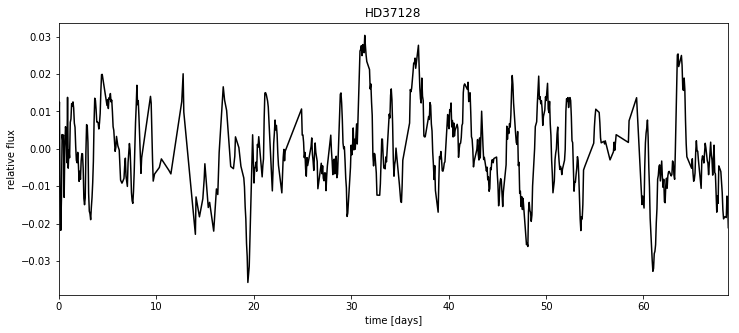

In [21]:
x = np.ascontiguousarray(data.time - np.min(data.time), dtype=np.float64)
y = np.ascontiguousarray(data.flux, dtype=np.float64)
yerr = np.ascontiguousarray(data.flux_err, dtype=np.float64)

plt.plot(x, y, "k")
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.title("HD37128");

## A Gaussian process model for stellar variability

This looks like the light curve of a rotating star, and [it has been shown](https://arxiv.org/abs/1706.05459) that it is possible to model this variability by using a quasiperiodic Gaussian process.
To start with, let's get an estimate of the rotation period using the Lomb-Scargle periodogram:

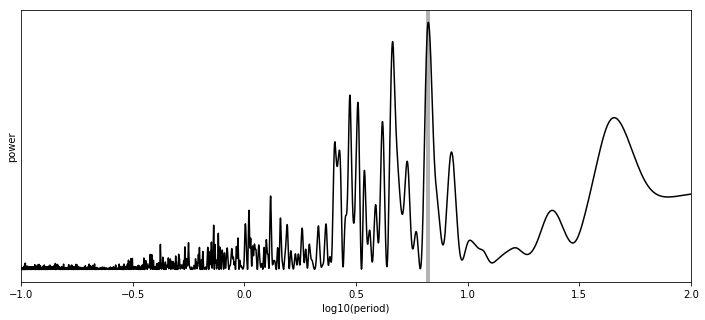

In [22]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=0.1, max_period=100.0,
    samples_per_peak=50)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(peak["period"]), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power");

Now, using this initialization, we can set up the GP model in *exoplanet*.
We'll use the :class:`exoplanet.gp.terms.RotationTerm` kernel that is a mixture of two simple harmonic oscillators with periods separated by a factor of two.
As you can see from the periodogram above, this might be a good model for this light curve and I've found that it works well in many cases.

In [23]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    
    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)
    
    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr)), sd=5.0)
    
    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
    logperiod = pm.Normal("logperiod", mu=np.log(peak["period"]), sd=5.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = pm.Uniform("mix", lower=0, upper=1.0)
    
    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))
    
    # Set up the Gaussian Process model
    kernel = xo.gp.terms.RotationTerm(
        log_amp=logamp,
        period=period,
        log_Q0=logQ0,
        log_deltaQ=logdeltaQ,
        mix=mix
    )
    gp = xo.gp.GP(kernel, x, yerr**2 + tt.exp(logs2), J=4)
    
    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    pm.Potential("loglike", gp.log_likelihood(y - mean))
    
    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())
    
    # Optimize to find the maximum a posteriori parameters
    map_soln = pm.find_MAP(start=model.test_point)

logp = 2,588.8, ||grad|| = 2.3087: 100%|██████████| 66/66 [00:00<00:00, 614.13it/s]  


Now that we have the model set up, let's plot the maximum a posteriori model prediction.

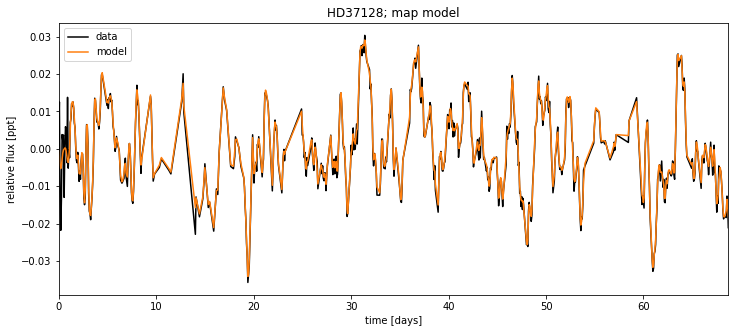

In [24]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("HD37128; map model");

That looks pretty good!
Now let's sample from the posterior using a :class:`exoplanet.PyMC3Sampler`.

In [25]:
np.random.seed(42)
sampler = xo.PyMC3Sampler()
with model:
    sampler.tune(tune=2000, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=2000)

Only 2 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logs2, mean]
Sampling 4 chains: 100%|██████████| 308/308 [00:14<00:00,  7.49draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only 2 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logs2, mean]
Sampling 4 chains: 100%|██████████| 108/108 [00:05<00:00, 21.09draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_t

Now we can do the usual convergence checks:

In [26]:
pm.summary(trace, varnames=["mix", "logdeltaQ", "logQ0", "logperiod", "logamp", "logs2", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mix,0.519675,0.258571,0.006028,0.105581,0.995496,2131.768098,1.001121
logdeltaQ,-2.784173,9.571919,0.535766,-21.642989,17.319353,203.542583,1.006698
logQ0,-5.769875,3.618373,0.193458,-13.266628,-1.575573,154.668885,1.008797
logperiod,3.012790,1.836539,0.101910,0.932272,6.823912,139.271848,1.009326
logamp,-10.628248,1.538499,0.099824,-14.061090,-8.885212,97.152508,1.012472
logs2,-18.877306,2.970511,0.063388,-24.802369,-14.354169,2045.226230,1.000187
mean,-0.000665,0.001394,0.000026,-0.003422,0.002024,3019.424184,1.000024


And plot the posterior distribution over rotation period:

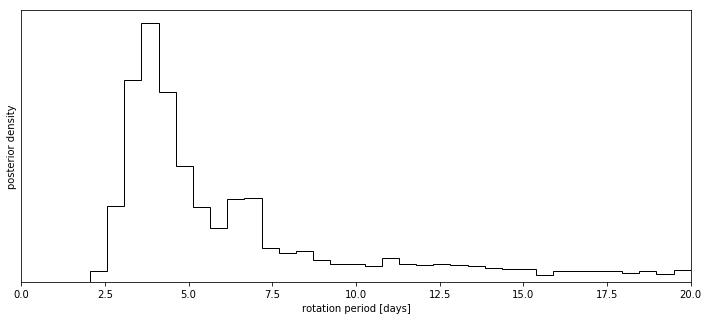

In [27]:
period_samples = trace["period"]
bins = np.linspace(0, 20, 40)
plt.hist(period_samples, bins, histtype="step", color="k")
plt.yticks([])
plt.xlim(bins.min(), bins.max())
plt.xlabel("rotation period [days]")
plt.ylabel("posterior density");


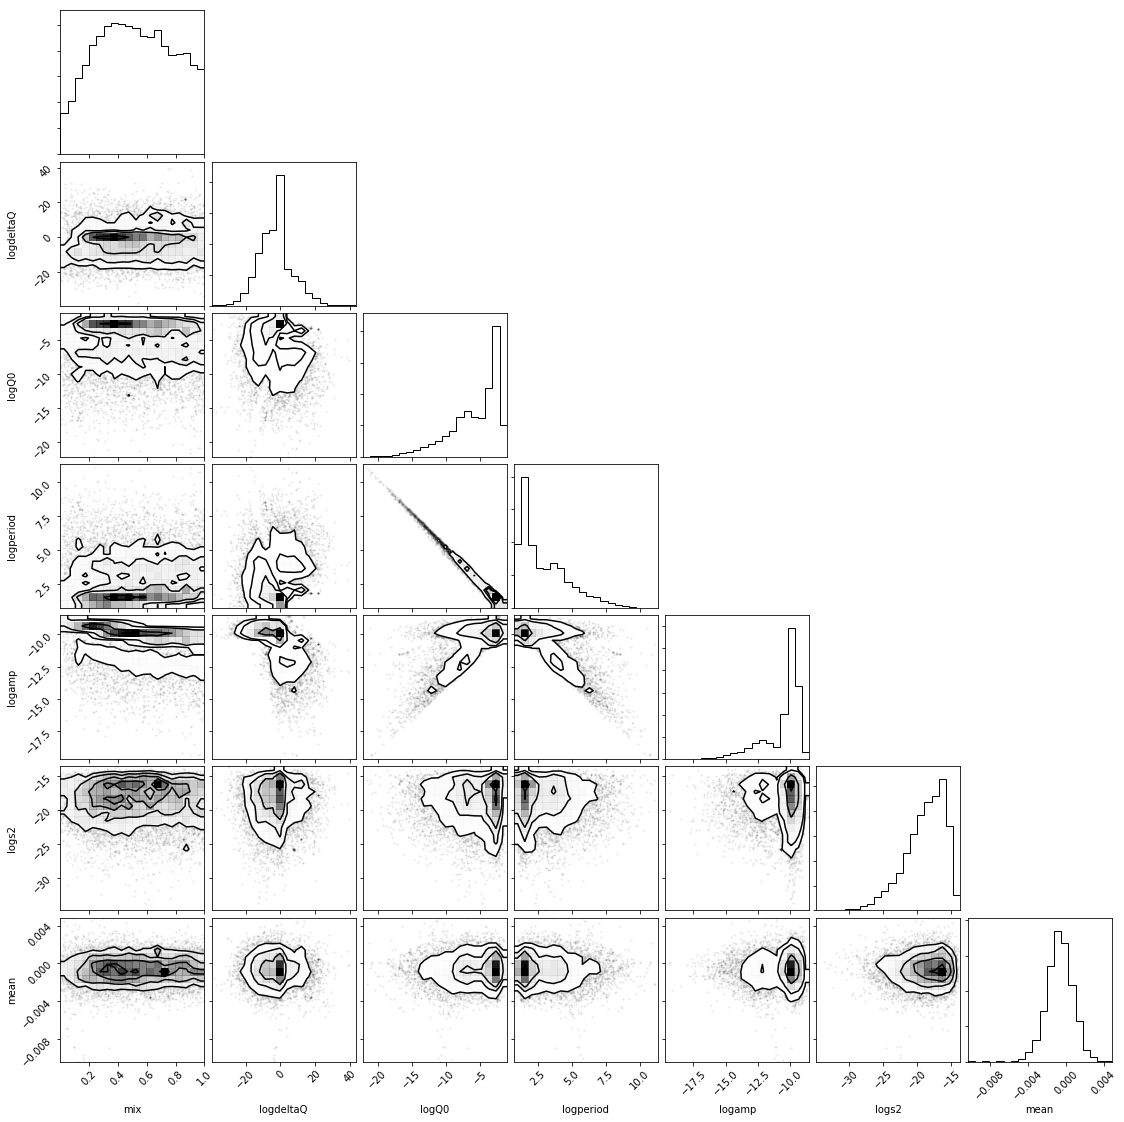

In [32]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["mix", "logdeltaQ", "logQ0", "logperiod", "logamp", "logs2", "mean"])
corner.corner(samples);

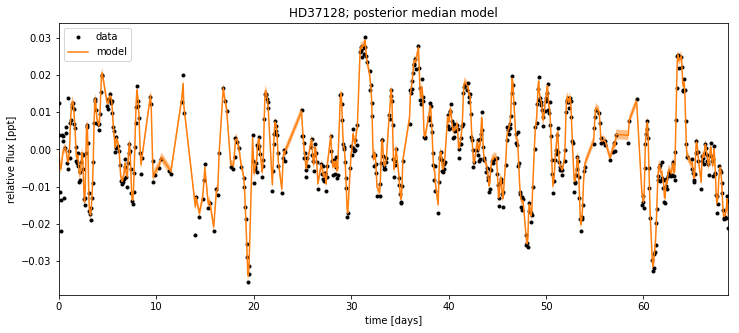

In [33]:
plt.plot(x, y, ".k", label="data")

q = np.percentile(trace["pred"], [16, 50, 84], axis=0)
plt.plot(x, q[1], color="C1", label="model")
art = plt.fill_between(x, q[0], q[2], color="C1", alpha=0.5)
art.set_edgecolor("none")

plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("HD37128; posterior median model");